In [2]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Install DeepRobust (from Lorenzo fork)

!pip install --upgrade texttable git+https://github.com/lorenzobasile/DeepRobust.git

  Cloning https://github.com/lorenzobasile/DeepRobust.git to /tmp/pip-req-build-wedwgkvr
  Running command git clone -q https://github.com/lorenzobasile/DeepRobust.git /tmp/pip-req-build-wedwgkvr
     |████████████████████████████████| 204kB 8.6MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142494 sha256=bd36456e0617639bd03db5afe704fbd7351d365e7bd3bba9389b759bb11bf979
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnaf0olm/wheels/73/c5/ae/8043f3f08a70c4c2a4584449a4f97f415682a4f0371f8f3890
Successfully built deeprobust
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [4]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 1.6MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=d4c737ac78ae32aeb73260ea4992c41ac838e4c6c493d4b73d1c4ecf1931b8ac
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [5]:
# Going to my directory

%cd gdrive/My\ Drive/Colab Notebooks/project_rob

/content/gdrive/My Drive/Colab Notebooks/project_rob


In [6]:
%ls -lhtr classes/

total 1.5K
-rw------- 1 root root 1.3K Jun 19 17:45 classes.txt


In [7]:
## LIBRARIES

## Usual python tools
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

## Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Torchvision
import torchvision 

## DeepRobust
import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.defense.fast import Fast
from deeprobust.image.defense.YOPO import YOPOpgd
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import deeprobust.image.netmodels.CNN as MODEL
from torchvision import transforms, datasets
from deeprobust.image.defense.fgsmtraining import FGSMtraining 
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net
import pandas as pd
from advertorch.attacks import SinglePixelAttack
from advertorch.attacks import GradientSignAttack

In [8]:
## LOAD CLASSES AND BUILD DICTIONARY

signs = pd.read_table("classes/classes.txt", header=None, names=['Belgium signs'])

dicts = {}
for i in range(0,62):
  dicts[i] = signs['Belgium signs'][i]

print(dicts)

{0: 'uneven road', 1: 'humps', 2: 'slippery road', 3: 'bend, to left', 4: 'bend, to right', 5: 'double bend, first to left', 6: 'double bend, first to right', 7: 'children', 8: 'bicycle crossing', 9: 'cattle', 10: 'road works', 11: 'traffic lights', 12: 'level crossing with barrier', 13: 'other danger', 14: 'road narrows', 15: 'road narrows on left', 16: 'road narrows on right', 17: 'crossroads', 18: 'crossroads with right-of-way from the right', 19: 'give way', 20: 'priority from opposite direction', 21: 'stop', 22: 'no entry', 23: 'no bicycles', 24: 'max weight', 25: 'no heavy load', 26: 'max width', 27: 'max height', 28: 'traffic not allowed', 29: 'no turn left', 30: 'no turn right', 31: 'no overtaking', 32: 'max speed', 33: 'pedestrian zone', 34: 'drive straight', 35: 'turn', 36: 'drive straight or turn right', 37: 'roundabout', 38: 'bicycles only', 39: 'bicycles and pedestrians', 40: 'no parking', 41: 'no stopping on the side ', 42: 'no parking', 43: 'no parking 16-31', 44: 'prior

In [9]:
dicts[21]

'stop'

In [10]:
torch.manual_seed(torch.rand(1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [11]:
## SOME USEFUL FUNCTIONS

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, vmin=0, vmax=1)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
           
    return float(n_right) / tot

In [12]:
## TRANSFORMATIONS

data_transforms = {'Training': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ]),
                   'Testing': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ])
                   }

In [13]:
## LOADING DATA

# Location of data
data_dir = './data/'

# Load dataset
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
# Create dataloaders (test and train)
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=64, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=64, shuffle=True)}

# Save sizes and classes
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

In [14]:
## PRINT SOME INFO ABOUT DATA

print(dataloaders['Training'].dataset)
print()
print(dataloaders['Testing'].dataset)

Dataset ImageFolder
    Number of datapoints: 4613
    Root location: ./data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: ./data/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )


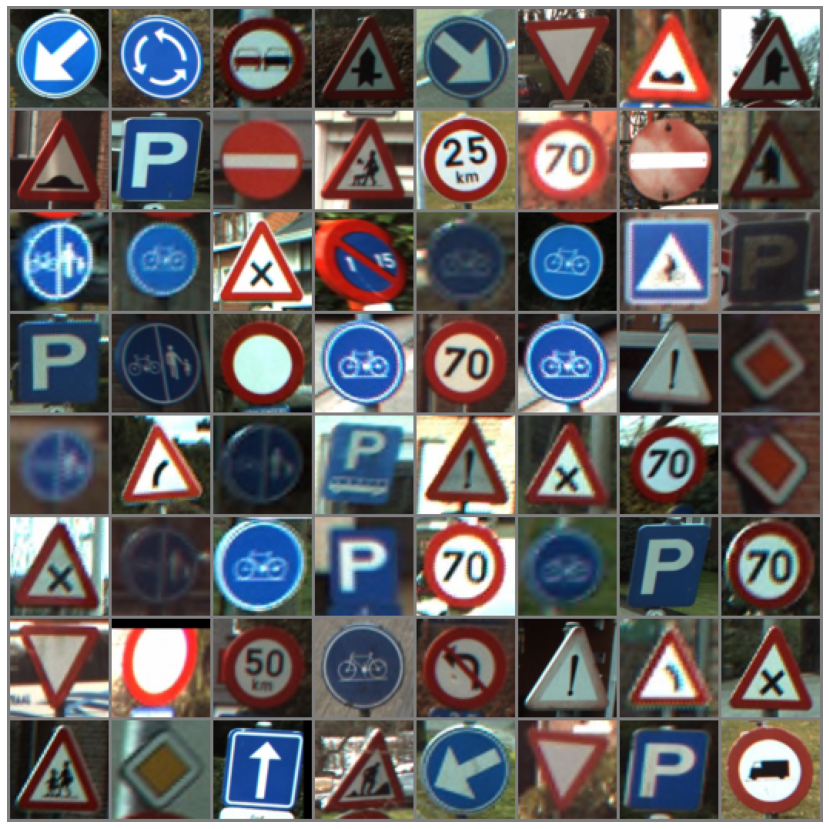

In [ ]:
## PRINT SOME IMAGES
plt.figure(figsize=(18,15))
# Train
inputs, classes = next(iter(dataloaders['Training']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Test
inputs, classes = next(iter(dataloaders['Testing']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [15]:
## LOAD GOOGLENET

net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,62)
net.to(device)
net.load_state_dict(torch.load("models/64_20e.h5"), strict=False)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


<All keys matched successfully>

In [ ]:
## EVALUATE TEST ACCURACY

net.eval()
acc_test = get_accuracy(dataloaders['Testing'], net, device=device)
print("\nTest accuracy: {}".format(acc_test))


Test accuracy: 0.9837301587301587


In [ ]:
def return_image(label):
  for data, targets in dataloaders['Testing']:

    good = (targets == label)
    
    if (good.size()[0] != 0):
      correct_images = data[good,:,:,:]
      return correct_images 

  return None 

In [ ]:
x = return_image(21)

In [ ]:
x.size()

torch.Size([2, 3, 64, 64])

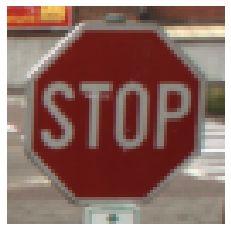

In [ ]:
imshow(x[0])

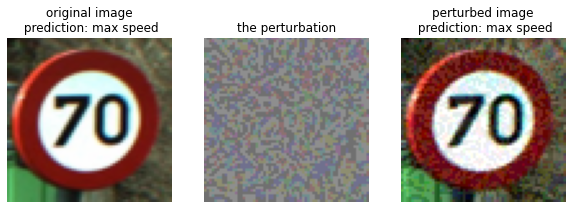

In [ ]:
attack = GradientSignAttack(net, eps=0.2, clip_min=-np.inf, clip_max=np.inf, targeted=True)

x, y = next(iter(dataloaders['Testing']))

x = x.to('cuda').float()
label_fool = torch.tensor([21 for i in range(64)])
label_fool = label_fool.to('cuda')

adv_img = attack.perturb(x, label_fool)

out = net(adv_img)
pred = torch.argmax(out, dim=1)

_show_images(img=x[0].cpu().detach(), advimg=adv_img[0].cpu().detach(), 
             pred=y[0].item(), advpred=pred[0].item() )

In [ ]:
def _show_images(img, advimg, pred, advpred):
    
    perturb = advimg - img
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])

    plt.figure(figsize=(10, 8))

    plt.subplot(1, 3, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("original image\n prediction: {}".format(dicts[pred]))
    
    plt.subplot(1, 3, 2)
    perturb = perturb.numpy().transpose((1, 2, 0))
    perturb = std * perturb + mean
    perturb = np.clip(perturb, 0, 1)
    plt.imshow(perturb)
    plt.axis("off")
    plt.title("the perturbation")
    
    plt.subplot(1, 3, 3)
    advimg = advimg.numpy().transpose((1, 2, 0))
    advimg = std * advimg + mean
    advimg = np.clip(advimg, 0, 1)
    plt.imshow(advimg)
    plt.axis("off")
    plt.title("perturbed image\n prediction: {}".format(dicts[advpred]))
    plt.show()

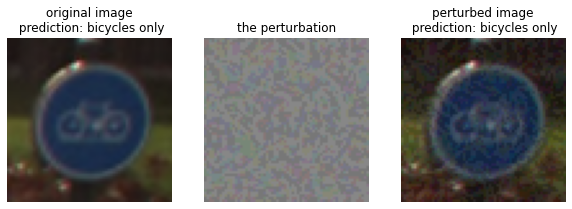

In [ ]:
## FGSM Attack

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()

adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv_before = net(Adv_img)
output_img_before = net(x)


_show_images(img=x[0].cpu().detach(), advimg=Adv_img[0].cpu().detach(), 
             pred=torch.argmax(output_img_before, dim=1)[0].item(), advpred=torch.argmax(output_adv_before, dim=1)[0].item())

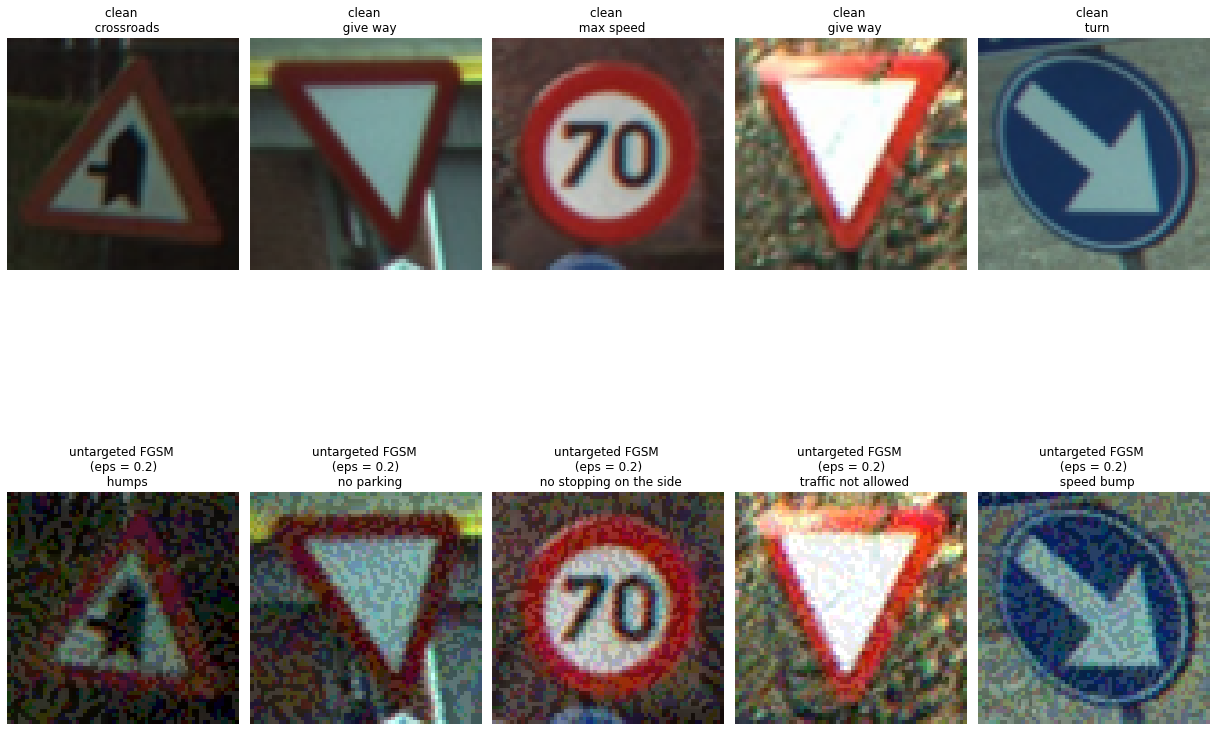

In [ ]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.2)

x, y = next(iter(dataloaders['Testing']))
x = x.to('cuda').float()

adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.1)

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(17,15))
batch_size = 5

for ii in range(5):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted FGSM \n (eps = {}) \n  {}".format(0.1, dicts[advpred[ii].item()]))

plt.tight_layout()
plt.show()

In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET 

epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
adversarial_accuracies_before = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  
  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]

    # Call FGSM Attack
    adversary = FGSM(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_before.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

Epsilon = 0.3: adversarial test Accuracy = 679 / 2520 -> 26.94%
Epsilon = 0.2: adversarial test Accuracy = 891 / 2520 -> 35.36%
Epsilon = 0.15: adversarial test Accuracy = 1073 / 2520 -> 42.58%
Epsilon = 0.1: adversarial test Accuracy = 1391 / 2520 -> 55.20%
Epsilon = 0.05: adversarial test Accuracy = 1926 / 2520 -> 76.43%
Epsilon = 0.03: adversarial test Accuracy = 2165 / 2520 -> 85.91%
Epsilon = 0.01: adversarial test Accuracy = 2387 / 2520 -> 94.72%


Text(0, 0.5, 'Accuracy')

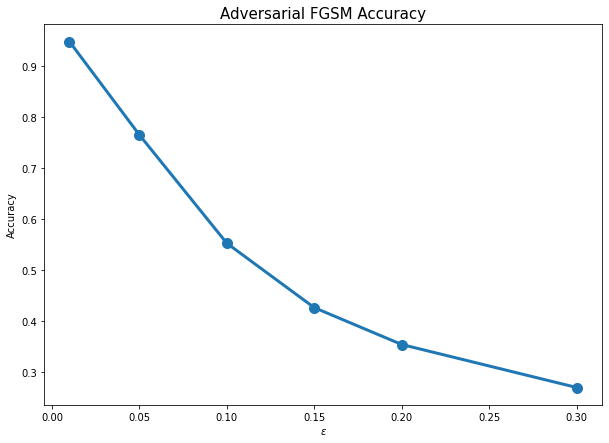

In [20]:
## PLOT ACCURACIES BEFORE/AFTER ADVERSARIAL TRAINING

plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.01]
adversarial_accuracies_before = [0.2694, 0.3536, 0.4258, 0.5520, 0.7643, 0.9472]
plt.plot(epsilons, adversarial_accuracies_before, lw=3, linestyle='-', marker='o', markersize=10)
plt.title("Adversarial FGSM Accuracy", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)

In [ ]:
### ADVERSARIAL TRAINING (DON'T RUN ANYMORE!!)

epsilons = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]

for eps in epsilons:
    
    net.to(device)
    net.load_state_dict(torch.load("models/64_20e.h5"), strict=False)
    
    defense = FGSMtraining(net, device)
    defense.generate(train_loader=dataloaders['Training'], test_loader=dataloaders['Testing'], epsilon=eps, epoch_num= 20,
                    lr_train = 0.001, save_model = False)
    torch.save(net.state_dict(), "models/fgsm_64_20e_good_eps%f.h5"%eps)

1
Train Epoch: 1 [0/4613 (0%)]	Loss: -5.845493	Accuracy:10.00%
Train Epoch: 1 [640/4613 (14%)]	Loss: -13.775074	Accuracy:99.06%
Train Epoch: 1 [1280/4613 (27%)]	Loss: -18.590824	Accuracy:99.53%
Train Epoch: 1 [1920/4613 (41%)]	Loss: -23.899256	Accuracy:99.06%
Train Epoch: 1 [2560/4613 (55%)]	Loss: -28.976505	Accuracy:99.38%
Train Epoch: 1 [3200/4613 (68%)]	Loss: -32.187630	Accuracy:99.38%
Train Epoch: 1 [3840/4613 (82%)]	Loss: -37.795921	Accuracy:98.91%
Train Epoch: 1 [4480/4613 (96%)]	Loss: -43.266445	Accuracy:99.38%

Test set: Clean loss: -46.033, Clean Accuracy: 2486/2520 (99%)


Test set: Adv loss: -46.546, Adv Accuracy: 2432/2520 (97%)

model saved in ./defense_models
2
Train Epoch: 2 [0/4613 (0%)]	Loss: -44.994167	Accuracy:10.00%
Train Epoch: 2 [640/4613 (14%)]	Loss: -50.393688	Accuracy:99.53%
Train Epoch: 2 [1280/4613 (27%)]	Loss: -55.522034	Accuracy:99.38%
Train Epoch: 2 [1920/4613 (41%)]	Loss: -59.949928	Accuracy:99.38%
Train Epoch: 2 [2560/4613 (55%)]	Loss: -66.481064	Accurac

In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET AFTER ADVERSARIAL TRAINING

epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]
adversarial_accuracies_after = []

# Evaluate model on adversarial attacks
for eps in epsilons:
  net.load_state_dict(torch.load('models/fgsm_64_20e_eps%f.h5'%eps), strict=False) 

  correct = 0
  batch_number = 0
  tot = len(dataloaders['Testing'].dataset)
  
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]


    # Call FGSM Attack
    adversary = FGSM(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = eps)

    # Re-classify the perturbed image
    output = net(Adv_img)

    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

    correct += torch.sum(target == final_pred)

  adversarial_accuracies_after.append(float(correct)/float(tot))
  print("Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

Epsilon = 0.3: adversarial test Accuracy = 2291 / 2520 -> 90.91%
Epsilon = 0.2: adversarial test Accuracy = 2361 / 2520 -> 93.69%
Epsilon = 0.15: adversarial test Accuracy = 2392 / 2520 -> 94.92%
Epsilon = 0.1: adversarial test Accuracy = 2407 / 2520 -> 95.52%
Epsilon = 0.05: adversarial test Accuracy = 2428 / 2520 -> 96.35%
Epsilon = 0.03: adversarial test Accuracy = 2436 / 2520 -> 96.67%
Epsilon = 0.01: adversarial test Accuracy = 2444 / 2520 -> 96.98%


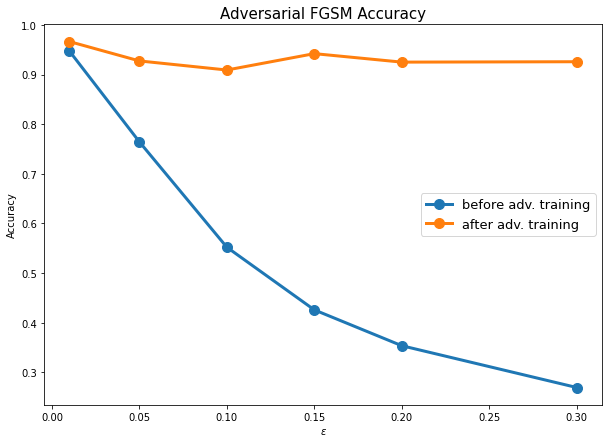

In [21]:
## PLOT ACCURACIES BEFORE/AFTER ADVERSARIAL TRAINING

plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.01]


adversarial_accuracies_after = [0.9258, 0.9250, 0.9421, 0.9091, 0.9274, 0.9664]

plt.plot(epsilons, adversarial_accuracies_before, lw=3, label='before adv. training', linestyle='-', marker='o', markersize=10)
plt.plot(epsilons, adversarial_accuracies_after, lw=3, label='after adv. training', linestyle='-', marker='o', markersize=10)
plt.title("Adversarial FGSM Accuracy", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend(loc = 'center right', fontsize=13)
#plt.savefig("plots/fgsm_attack_good.png")
plt.show()

In [ ]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.2)
## THE NET NOW HAS DONE ADV.TRAINING


net.load_state_dict(torch.load('models/fgsm_64_20_good_eps%f.h5'%epsilons[1]), strict=False)


adversary = FGSM(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = 0.2)

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(18,15))
batch_size = 5

for ii in range(5):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted FGSM \n (eps = {}) \n  {}".format(0.2, dicts[advpred[ii].item()]))

plt.tight_layout()
plt.show()

NameError: ignored

In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET AFTER ADVERSARIAL TRAINING

epsilons = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

net.eval()
adversarial_accuracies_after = []

accuracies = torch.zeros((len(epsilons), len(epsilons)))

# Evaluate model on adversarial attacks
for eps_i in range(len(epsilons)):
  print('load models/fgsm_64_20e_good_eps%f.h5'%epsilons[eps_i])
  net.load_state_dict(torch.load('models/fgsm_64_20e_good_eps%f.h5'%epsilons[eps_i]), strict=False) 
  print("defense epsilon=",epsilons[eps_i])
  
  for eps_j in range(len(epsilons)): 

    correct = 0
    batch_number = 0
    tot = len(dataloaders['Testing'].dataset)
    
    for data, target in dataloaders['Testing']:
    
      #Send the data and label to the device
      data, target = data.to('cuda'), target.to('cuda')
      batch_size = data.size()[0]

      ## Call PGD Attack
      adversary = FGSM(net, 'cuda')
      Adv_img = adversary.generate(data, target, epsilon = epsilons[eps_j])

      # Re-classify the perturbed image
      output = net(Adv_img)

      # Check for success
      final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

      correct += torch.sum(target == final_pred)

    accuracies[eps_i][eps_j] = (float(correct)/float(tot))
   
    print("attack Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(epsilons[eps_j], correct, tot, float(correct)/float(tot)*100))

load models/fgsm_64_20e_good_eps0.010000.h5
defense epsilon= 0.01
attack Epsilon = 0.01: adversarial test Accuracy = 2441 / 2520 -> 96.87%
attack Epsilon = 0.05: adversarial test Accuracy = 2435 / 2520 -> 96.63%
attack Epsilon = 0.1: adversarial test Accuracy = 2433 / 2520 -> 96.55%
attack Epsilon = 0.15: adversarial test Accuracy = 2433 / 2520 -> 96.55%
attack Epsilon = 0.2: adversarial test Accuracy = 2429 / 2520 -> 96.39%
attack Epsilon = 0.3: adversarial test Accuracy = 2420 / 2520 -> 96.03%
load models/fgsm_64_20e_good_eps0.050000.h5
defense epsilon= 0.05
attack Epsilon = 0.01: adversarial test Accuracy = 2440 / 2520 -> 96.83%
attack Epsilon = 0.05: adversarial test Accuracy = 2432 / 2520 -> 96.51%
attack Epsilon = 0.1: adversarial test Accuracy = 2425 / 2520 -> 96.23%
attack Epsilon = 0.15: adversarial test Accuracy = 2423 / 2520 -> 96.15%
attack Epsilon = 0.2: adversarial test Accuracy = 2420 / 2520 -> 96.03%
attack Epsilon = 0.3: adversarial test Accuracy = 2410 / 2520 -> 95.63

In [ ]:
accuracies[:,0]

tensor([0.9698, 0.9683, 0.9671, 0.9663, 0.9651, 0.9635, 0.9587])

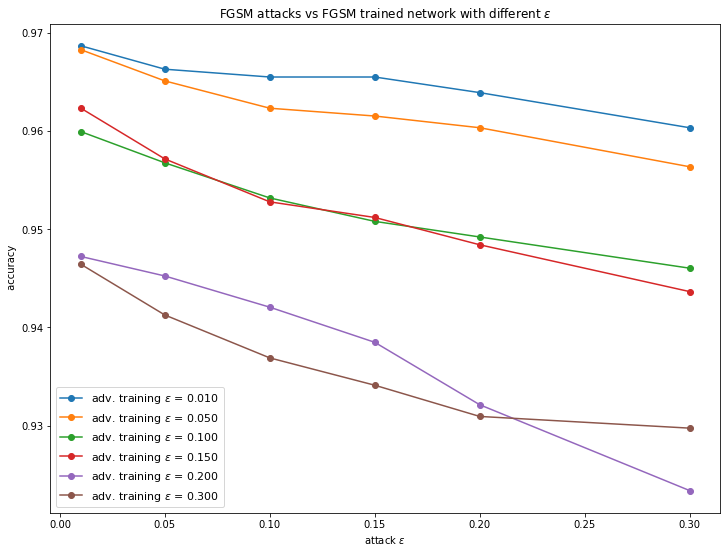

In [ ]:
plt.figure(figsize=(12, 9))

for i in range(len(epsilons)):
  plt.plot(epsilons, accuracies[i,:], label='adv. training $\epsilon$ = {:.3f}'.format(epsilons[i]),marker='o')

plt.xlabel("attack $\epsilon$")
plt.ylabel(" accuracy")
plt.title("FGSM attacks vs FGSM trained network with different $\epsilon$")
plt.legend(loc=3, prop={'size': 11})
#plt.ylim(0.850, 0.975)
plt.show()

In [ ]:
#accuracies[:][1]

In [ ]:
net.load_state_dict(torch.load('models/fgsm_64_20e_eps%f.h5'%epsilons[0]), strict=False) 

correct = 0
batch_number = 0
tot = len(dataloaders['Testing'].dataset)
    
  for data, target in dataloaders['Testing']:
  
    #Send the data and label to the device
    data, target = data.to('cuda'), target.to('cuda')
    batch_size = data.size()[0]
    ## Call PGD Attack
    adversary = FGSM(net, 'cuda')
    Adv_img = adversary.generate(data, target, epsilon = epsilons[eps_j])
    print("attack done with epsilon=", )
    # Re-classify the perturbed image
    output = net(Adv_img)
    # Check for success
    final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
    correct += torch.sum(target == final_pred)
  accuracies[eps_i][eps_j] = (float(correct)/float(tot))
  
  print("defense Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(epsilons[eps_j], correct, tot, float(correct)/float(tot)*100))